In [14]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"proyek17","key":"362f81ad155df4ddb7ac499b1a7edf9c"}'}

In [2]:
# === 1. Instalasi & Persiapan Dataset dari Kaggle ===
!pip install -q kaggle

# Setup credentials Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset HAM10000 dari Kaggle
!kaggle datasets download -d surajghuwalewala/ham1000-segmentation-and-classification

# Ekstraksi dataset ke folder 'ham10000'
import zipfile
with zipfile.ZipFile('ham1000-segmentation-and-classification.zip', 'r') as zip_ref:
    zip_ref.extractall('ham1000')

Dataset URL: https://www.kaggle.com/datasets/surajghuwalewala/ham1000-segmentation-and-classification
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
 97% 2.52G/2.59G [00:01<00:00, 1.33GB/s]
100% 2.59G/2.59G [00:01<00:00, 1.44GB/s]


In [3]:
import os, shutil, itertools, zipfile, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import architectures with alias to avoid preprocess conflict
from tensorflow.keras.applications.vgg16 import VGG16 as _VGG16, preprocess_input as preprocess_vgg
from tensorflow.keras.applications.resnet50 import ResNet50 as _ResNet50, preprocess_input as preprocess_resnet
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 as _MobileNetV2, preprocess_input as preprocess_mobilenet

print("TF:", tf.__version__)

TF: 2.19.0


In [17]:
base_path = Path("ham1000")
metadata_file = list(base_path.rglob("GroundTruth.csv"))[0]
df = pd.read_csv(metadata_file)

possible_cols = ['MEL','NV','BCC','AKIEC','BKL','DF','VASC']
df['dx'] = df[possible_cols].idxmax(axis=1)
img_dir = list(base_path.rglob("images"))[0]
df['path'] = df['image'].apply(lambda x: str(img_dir / f"{x}.jpg"))
df = df[df['path'].apply(os.path.exists)].reset_index(drop=True)

print("Total samples:", len(df))
print(df['dx'].value_counts())

Total samples: 10015
dx
NV       6705
MEL      1113
BKL      1099
BCC       514
AKIEC     327
VASC      142
DF        115
Name: count, dtype: int64


Classes: ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']


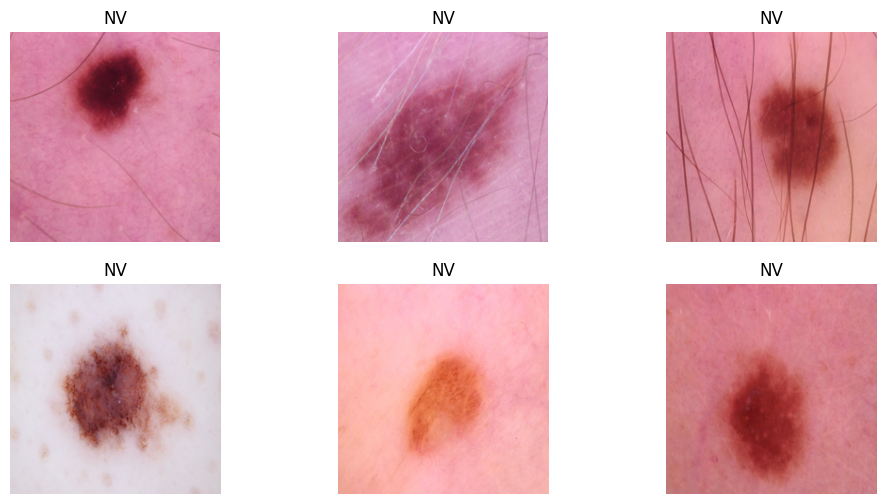

In [5]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32
EPOCHS = 30
SEED = 42
NUM_FOLDS = 1   # set >1 untuk k-fold CV

le = LabelEncoder()
le.fit(df['dx'])
num_classes = len(le.classes_)
print("Classes:", list(le.classes_))

# helper: show samples
def show_samples(df_in, n=6):
    samples = df_in.sample(n, random_state=SEED)
    plt.figure(figsize=(12,6))
    for i, (_, r) in enumerate(samples.iterrows()):
        img = Image.open(r['path']).resize(IMG_SIZE)
        plt.subplot(2,3,i+1); plt.imshow(img); plt.title(r['dx']); plt.axis('off')
    plt.show()
show_samples(df,6)



In [19]:
import tensorflow.keras.backend as K

def categorical_focal_loss(alpha=0.25, gamma=2.0):
    # returns a loss function for multi-class focal loss
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return loss

# MixUp
def mixup(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.shape[0]
    index = np.random.permutation(batch_size)
    x_mix = lam * x + (1 - lam) * x[index]
    y_mix = lam * y + (1 - lam) * y[index]
    return x_mix, y_mix

# CutMix (simple implementation)
def cutmix(images, labels, alpha=1.0):
    batch_size, H, W, _ = images.shape
    lam = np.random.beta(alpha, alpha)
    # random bbox
    rx = np.random.randint(W)
    ry = np.random.randint(H)
    rw = int(W * np.sqrt(1 - lam))
    rh = int(H * np.sqrt(1 - lam))
    x1 = np.clip(rx - rw//2, 0, W)
    y1 = np.clip(ry - rh//2, 0, H)
    x2 = np.clip(rx + rw//2, 0, W)
    y2 = np.clip(ry + rh//2, 0, H)
    index = np.random.permutation(batch_size)
    images[:, y1:y2, x1:x2, :] = images[index, y1:y2, x1:x2, :]
    lam_adjusted = 1 - ((x2-x1)*(y2-y1) / (W*H))
    labels = labels * lam_adjusted + labels[index] * (1 - lam_adjusted)
    return images, labels

In [20]:
def make_generators(preprocess_func, train_df, val_df, batch_size=BATCH_SIZE):
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_func,
        rotation_range=30,
        width_shift_range=0.12,
        height_shift_range=0.12,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )
    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_func)
    train_gen = train_datagen.flow_from_dataframe(
        train_df,
        x_col='path',
        y_col='dx',
        target_size=IMG_SIZE,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=SEED
    )
    val_gen = val_datagen.flow_from_dataframe(
        val_df,
        x_col='path',
        y_col='dx',
        target_size=IMG_SIZE,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    return train_gen, val_gen

def augment_generator_with_mix(train_gen, strategy='mixup', alpha=0.2):
    """Wrapper generator yang menambahkan MixUp atau CutMix."""
    while True:
        x, y = next(train_gen)  # FIX: gunakan next() (Keras 3 compatible)

        if strategy == 'mixup':
            x, y = mixup(x, y, alpha)

        elif strategy == 'cutmix':
            x, y = cutmix(x, y, alpha)

        # yield dalam format batch (x, y)
        yield x, y


In [8]:
def build_model(base_name='resnet', input_shape=(*IMG_SIZE,3), num_classes=num_classes, dropout_rate=0.4):
    if base_name == 'vgg':
        base = _VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_name == 'resnet':
        base = _ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_name == 'mobilenet':
        base = _MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError("base_name must be 'vgg', 'resnet', or 'mobilenet'")

    base.trainable = False
    inputs = layers.Input(shape=input_shape)
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(dropout_rate/2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs, name=f"{base_name}_transfer")
    return model, base

In [9]:
from sklearn.utils.class_weight import compute_class_weight

def train_model_pipeline(base_name, preprocess_func, train_df, val_df,
                         mix_strategy=None, focal=True, label_smooth=0.0,
                         fine_tune_at=None, epochs=EPOCHS, outdir="models_out"):
    os.makedirs(outdir, exist_ok=True)
    train_gen, val_gen = make_generators(preprocess_func, train_df, val_df)
    steps_per_epoch = len(train_gen)
    model, base = build_model(base_name)
    # choose loss
    if focal:
        loss_fn = categorical_focal_loss(alpha=0.25, gamma=2.0)
    else:
        loss_fn = keras.losses.CategoricalCrossentropy(label_smoothing=label_smooth)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss=loss_fn, metrics=['accuracy'])


    ckpt = os.path.join(outdir, f"{base_name}_best.h5")
    callbacks = [
        ModelCheckpoint(ckpt, monitor='val_accuracy', save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
    ]

    if mix_strategy in ['mixup','cutmix']:
        train_flow = augment_generator_with_mix(train_gen, strategy=mix_strategy)
        fit_args = dict(x=train_flow, steps_per_epoch=steps_per_epoch, epochs=epochs,
                        validation_data=val_gen, callbacks=callbacks, verbose=1)
    else:
        fit_args = dict(x=train_gen, epochs=epochs, validation_data=val_gen,
                        callbacks=callbacks, verbose=1)

    history = model.fit(**fit_args)

    # fine-tune (unfreeze top layers)
    if fine_tune_at is not None:
        base.trainable = True
        # freeze bottom layers up to fine_tune_at, unfreeze rest
        for layer in base.layers[:fine_tune_at]:
            layer.trainable = False
        for layer in base.layers[fine_tune_at:]:
            layer.trainable = True
        model.compile(optimizer=keras.optimizers.Adam(1e-5), loss=loss_fn, metrics=['accuracy'])
        ft_hist = model.fit(**fit_args)  # same generators
        # merge histories (optional)
        for k in ft_hist.history:
            history.history.setdefault(k, []).extend(ft_hist.history[k])

    # load best and evaluate on val_gen (or test later)
    model = keras.models.load_model(ckpt, compile=False)  # load without compile to avoid custom loss issues
    # compile back to use metrics
    if focal:
        model.compile(optimizer=keras.optimizers.Adam(1e-5), loss=categorical_focal_loss(), metrics=['accuracy'])
    else:
        model.compile(optimizer=keras.optimizers.Adam(1e-5),
                      loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smooth),
                      metrics=['accuracy'])
    # create preds on validation set for metrics (or separate test set if you have)
    val_gen_shuffle_false = ImageDataGenerator(preprocessing_function=preprocess_func).flow_from_dataframe(
        val_df, x_col='path', y_col='dx', target_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False
    )
    y_true = val_gen_shuffle_false.classes
    y_proba = model.predict(val_gen_shuffle_false, verbose=1)
    y_pred = np.argmax(y_proba, axis=1)
    labels_order = [k for k,v in sorted(val_gen_shuffle_false.class_indices.items(), key=lambda x:x[1])]

    # metrics
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=labels_order, digits=4, output_dict=False)

    # ROC AUC multiclass
    y_test_binarized = label_binarize(y_true, classes=np.arange(num_classes))
    fpr = dict(); tpr = dict(); roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    results = {
        'model': model,
        'history': history.history,
        'confusion_matrix': cm,
        'labels_order': labels_order,
        'classification_report_text': report,
        'roc': {'fpr':fpr,'tpr':tpr,'roc_auc':roc_auc},
        'y_true': y_true, 'y_pred': y_pred, 'y_proba': y_proba
    }
    return results


# Plot helpers

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label'); plt.xlabel('Predicted label'); plt.tight_layout()

def plot_roc_multiclass(roc_dict, classes):
    plt.figure(figsize=(8,6))
    for i, cls in enumerate(classes):
        plt.plot(roc_dict['fpr'][i], roc_dict['tpr'][i], lw=2, label=f'{cls} (AUC={roc_dict["roc_auc"][i]:.3f})')
    plt.plot(roc_dict['fpr']['micro'], roc_dict['tpr']['micro'], label=f'micro (AUC={roc_dict["roc_auc"]["micro"]:.3f})', linestyle='--')
    plt.plot([0,1],[0,1],'k--',lw=1)
    plt.xlim([0,1]); plt.ylim([0,1.05]); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(loc='lower right'); plt.grid(True)

Train: 8012 Val: 1001 Test: 1002
Found 8012 validated image filenames belonging to 7 classes.
Found 1001 validated image filenames belonging to 7 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.5695 - loss: 0.2465

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.68332, saving model to results_vgg/vgg_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 153s 576ms/step - accuracy: 0.5697 - loss: 0.2463 - val_accuracy: 0.6833 - val_loss: 0.1406 - learning_rate: 1.0000e-04
Epoch 2/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.6617 - loss: 0.1662
Epoch 2: val_accuracy improved from 0.68332 to 0.69930, saving model to results_vgg/vgg_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 132s 529ms/step - accuracy: 0.6618 - loss: 0.1662 - val_accuracy: 0.6993 - val_loss: 0.1262 - learning_rate: 1.0000e-04
Epoch 3/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.6763 - loss: 0.1468
Epoch 3: val_accuracy improved from 0.69930 to 0.71029, saving model to results_vgg/vgg_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 131s 525ms/step - accuracy: 0.6763 - loss: 0.1468 - val_accuracy: 0.7103 - val_loss: 0.1162 - learning_rate: 1.0000e-04
Epoch 4/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.6751 - loss: 0.1432
Epoch 4: val_accuracy improved from 0.71029 to 0.71329, saving model to results_vgg/vgg_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 129s 515ms/step - accuracy: 0.6752 - loss: 0.1432 - val_accuracy: 0.7133 - val_loss: 0.1127 - learning_rate: 1.0000e-04
Epoch 5/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.6969 - loss: 0.1335
Epoch 5: val_accuracy improved from 0.71329 to 0.72727, saving model to results_vgg/vgg_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 126s 505ms/step - accuracy: 0.6968 - loss: 0.1335 - val_accuracy: 0.7273 - val_loss: 0.1080 - learning_rate: 1.0000e-04
Epoch 6/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.6927 - loss: 0.1302
Epoch 6: val_accuracy improved from 0.72727 to 0.72927, saving model to results_vgg/vgg_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 127s 506ms/step - accuracy: 0.6927 - loss: 0.1302 - val_accuracy: 0.7293 - val_loss: 0.1048 - learning_rate: 1.0000e-04
Epoch 7/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.7006 - loss: 0.1290
Epoch 7: val_accuracy improved from 0.72927 to 0.74326, saving model to results_vgg/vgg_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 127s 509ms/step - accuracy: 0.7006 - loss: 0.1290 - val_accuracy: 0.7433 - val_loss: 0.1019 - learning_rate: 1.0000e-04
Epoch 8/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.7184 - loss: 0.1211
Epoch 8: val_accuracy improved from 0.74326 to 0.74625, saving model to results_vgg/vgg_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 127s 508ms/step - accuracy: 0.7183 - loss: 0.1211 - val_accuracy: 0.7463 - val_loss: 0.1002 - learning_rate: 1.0000e-04
Epoch 9/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.7135 - loss: 0.1208
Epoch 9: val_accuracy did not improve from 0.74625
251/251 ━━━━━━━━━━━━━━━━━━━━ 126s 504ms/step - accuracy: 0.7135 - loss: 0.1208 - val_accuracy: 0.7453 - val_loss: 0.0998 - learning_rate: 1.0000e-04
Epoch 10/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.7160 - loss: 0.1178
Epoch 10: val_accuracy did not improve from 0.74625
251/251 ━━━━━━━━━━━━━━━━━━━━ 127s 508ms/step - accuracy: 0.7160 - loss: 0.1179 - val_accuracy: 0.7463 - val_loss: 0.0984 - learning_rate: 1.0000e-04
Epoch 11/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.7220 - loss: 0.1168
Epoch 11: val_accuracy improved from 0.74625 to 0.75225, saving model to results_vgg/vgg_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 127s 507ms/step - accuracy: 0.7220 - loss: 0.1168 - val_accuracy: 0.7522 - val_loss: 0.0956 - learning_rate: 1.0000e-04
Epoch 12/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.7229 - loss: 0.1164
Epoch 12: val_accuracy improved from 0.75225 to 0.75524, saving model to results_vgg/vgg_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 126s 505ms/step - accuracy: 0.7229 - loss: 0.1164 - val_accuracy: 0.7552 - val_loss: 0.0957 - learning_rate: 1.0000e-04
Epoch 13/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.7325 - loss: 0.1099
Epoch 13: val_accuracy improved from 0.75524 to 0.75924, saving model to results_vgg/vgg_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 127s 507ms/step - accuracy: 0.7324 - loss: 0.1100 - val_accuracy: 0.7592 - val_loss: 0.0960 - learning_rate: 1.0000e-04
Epoch 14/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.7379 - loss: 0.1109
Epoch 14: val_accuracy improved from 0.75924 to 0.76024, saving model to results_vgg/vgg_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 126s 505ms/step - accuracy: 0.7379 - loss: 0.1109 - val_accuracy: 0.7602 - val_loss: 0.0945 - learning_rate: 1.0000e-04
Epoch 15/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.7304 - loss: 0.1166
Epoch 15: val_accuracy improved from 0.76024 to 0.76324, saving model to results_vgg/vgg_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 126s 505ms/step - accuracy: 0.7304 - loss: 0.1166 - val_accuracy: 0.7632 - val_loss: 0.0946 - learning_rate: 1.0000e-04
Epoch 16/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.7319 - loss: 0.1114
Epoch 16: val_accuracy improved from 0.76324 to 0.76923, saving model to results_vgg/vgg_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 127s 507ms/step - accuracy: 0.7319 - loss: 0.1114 - val_accuracy: 0.7692 - val_loss: 0.0941 - learning_rate: 1.0000e-04
Epoch 17/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.7282 - loss: 0.1088
Epoch 17: val_accuracy did not improve from 0.76923
251/251 ━━━━━━━━━━━━━━━━━━━━ 126s 503ms/step - accuracy: 0.7283 - loss: 0.1088 - val_accuracy: 0.7672 - val_loss: 0.0913 - learning_rate: 1.0000e-04
Epoch 18/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.7377 - loss: 0.1076
Epoch 18: val_accuracy did not improve from 0.76923
251/251 ━━━━━━━━━━━━━━━━━━━━ 126s 504ms/step - accuracy: 0.7377 - loss: 0.1076 - val_accuracy: 0.7672 - val_loss: 0.0909 - learning_rate: 1.0000e-04
Epoch 19/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.7498 - loss: 0.1060
Epoch 19: val_accuracy did not improve from 0.76923
251/251 ━━━━━━━━━━━━━━━━━━━━ 127s 507ms/step - accuracy: 0.7497 - loss: 0.1060 - val_accuracy: 0.7672 - val_loss: 0.0929 - learnin

251/251 ━━━━━━━━━━━━━━━━━━━━ 127s 507ms/step - accuracy: 0.7338 - loss: 0.1123 - val_accuracy: 0.7712 - val_loss: 0.0900 - learning_rate: 1.0000e-04
Epoch 22/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.7353 - loss: 0.1058
Epoch 22: val_accuracy did not improve from 0.77123
251/251 ━━━━━━━━━━━━━━━━━━━━ 126s 502ms/step - accuracy: 0.7354 - loss: 0.1058 - val_accuracy: 0.7562 - val_loss: 0.0890 - learning_rate: 1.0000e-04
Epoch 23/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.7505 - loss: 0.1014
Epoch 23: val_accuracy did not improve from 0.77123
251/251 ━━━━━━━━━━━━━━━━━━━━ 126s 504ms/step - accuracy: 0.7505 - loss: 0.1014 - val_accuracy: 0.7702 - val_loss: 0.0888 - learning_rate: 1.0000e-04
Epoch 24/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.7425 - loss: 0.1036
Epoch 24: val_accuracy did not improve from 0.77123
251/251 ━━━━━━━━━━━━━━━━━━━━ 126s 506ms/step - accuracy: 0.7425 - loss: 0.1036 - val_accuracy: 0.7662 - val_loss: 0.0896 - learnin

251/251 ━━━━━━━━━━━━━━━━━━━━ 143s 550ms/step - accuracy: 0.7676 - loss: 0.0997 - val_accuracy: 0.7842 - val_loss: 0.0808 - learning_rate: 1.0000e-05
Epoch 2/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.7697 - loss: 0.0926
Epoch 2: val_accuracy did not improve from 0.78422
251/251 ━━━━━━━━━━━━━━━━━━━━ 131s 525ms/step - accuracy: 0.7697 - loss: 0.0926 - val_accuracy: 0.7752 - val_loss: 0.0798 - learning_rate: 1.0000e-05
Epoch 3/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.7885 - loss: 0.0856
Epoch 3: val_accuracy improved from 0.78422 to 0.79021, saving model to results_vgg/vgg_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 130s 518ms/step - accuracy: 0.7885 - loss: 0.0856 - val_accuracy: 0.7902 - val_loss: 0.0779 - learning_rate: 1.0000e-05
Epoch 4/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.7864 - loss: 0.0869
Epoch 4: val_accuracy improved from 0.79021 to 0.79720, saving model to results_vgg/vgg_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 127s 507ms/step - accuracy: 0.7864 - loss: 0.0869 - val_accuracy: 0.7972 - val_loss: 0.0721 - learning_rate: 1.0000e-05
Epoch 5/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.7965 - loss: 0.0876
Epoch 5: val_accuracy did not improve from 0.79720
251/251 ━━━━━━━━━━━━━━━━━━━━ 127s 509ms/step - accuracy: 0.7965 - loss: 0.0876 - val_accuracy: 0.7802 - val_loss: 0.0757 - learning_rate: 1.0000e-05
Epoch 6/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.7968 - loss: 0.0818
Epoch 6: val_accuracy improved from 0.79720 to 0.81019, saving model to results_vgg/vgg_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 128s 512ms/step - accuracy: 0.7968 - loss: 0.0818 - val_accuracy: 0.8102 - val_loss: 0.0674 - learning_rate: 1.0000e-05
Epoch 7/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.7983 - loss: 0.0846
Epoch 7: val_accuracy did not improve from 0.81019
251/251 ━━━━━━━━━━━━━━━━━━━━ 127s 507ms/step - accuracy: 0.7983 - loss: 0.0846 - val_accuracy: 0.8032 - val_loss: 0.0694 - learning_rate: 1.0000e-05
Epoch 8/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.8099 - loss: 0.0824
Epoch 8: val_accuracy improved from 0.81019 to 0.81219, saving model to results_vgg/vgg_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 127s 507ms/step - accuracy: 0.8099 - loss: 0.0824 - val_accuracy: 0.8122 - val_loss: 0.0652 - learning_rate: 1.0000e-05
Epoch 9/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.8082 - loss: 0.0758
Epoch 9: val_accuracy did not improve from 0.81219
251/251 ━━━━━━━━━━━━━━━━━━━━ 127s 507ms/step - accuracy: 0.8083 - loss: 0.0758 - val_accuracy: 0.7992 - val_loss: 0.0674 - learning_rate: 1.0000e-05
Epoch 10/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.8005 - loss: 0.0810
Epoch 10: val_accuracy did not improve from 0.81219
251/251 ━━━━━━━━━━━━━━━━━━━━ 127s 506ms/step - accuracy: 0.8005 - loss: 0.0810 - val_accuracy: 0.8122 - val_loss: 0.0680 - learning_rate: 1.0000e-05
Epoch 11/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.8103 - loss: 0.0789
Epoch 11: val_accuracy improved from 0.81219 to 0.82318, saving model to results_vgg/vgg_best.h5



Epoch 11: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
251/251 ━━━━━━━━━━━━━━━━━━━━ 128s 511ms/step - accuracy: 0.8102 - loss: 0.0789 - val_accuracy: 0.8232 - val_loss: 0.0665 - learning_rate: 1.0000e-05
Epoch 12/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.8250 - loss: 0.0725
Epoch 12: val_accuracy improved from 0.82318 to 0.82517, saving model to results_vgg/vgg_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 128s 510ms/step - accuracy: 0.8250 - loss: 0.0725 - val_accuracy: 0.8252 - val_loss: 0.0635 - learning_rate: 5.0000e-06
Epoch 13/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.8207 - loss: 0.0765
Epoch 13: val_accuracy did not improve from 0.82517
251/251 ━━━━━━━━━━━━━━━━━━━━ 127s 509ms/step - accuracy: 0.8207 - loss: 0.0765 - val_accuracy: 0.8222 - val_loss: 0.0637 - learning_rate: 5.0000e-06
Epoch 14/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.8292 - loss: 0.0731
Epoch 14: val_accuracy did not improve from 0.82517
251/251 ━━━━━━━━━━━━━━━━━━━━ 127s 509ms/step - accuracy: 0.8292 - loss: 0.0731 - val_accuracy: 0.8212 - val_loss: 0.0629 - learning_rate: 5.0000e-06
Epoch 15/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.8194 - loss: 0.0734
Epoch 15: val_accuracy did not improve from 0.82517
251/251 ━━━━━━━━━━━━━━━━━━━━ 127s 509ms/step - accuracy: 0.8194 - loss: 0.0734 - val_accuracy: 0.8112 - val_loss: 0.0681 - learnin

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 231ms/step
              precision    recall  f1-score   support

       AKIEC     0.6957    0.4848    0.5714        33
         BCC     0.8529    0.5686    0.6824        51
         BKL     0.7033    0.5818    0.6368       110
          DF     0.8571    0.5000    0.6316        12
         MEL     0.5905    0.5586    0.5741       111
          NV     0.8774    0.9507    0.9126       670
        VASC     0.8000    0.8571    0.8276        14

    accuracy                         0.8252      1001
   macro avg     0.7681    0.6431    0.6909      1001
weighted avg     0.8179    0.8252    0.8172      1001



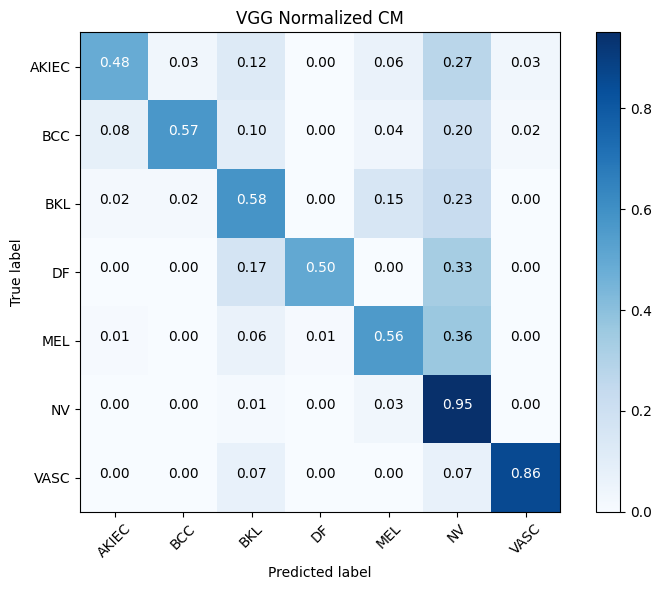

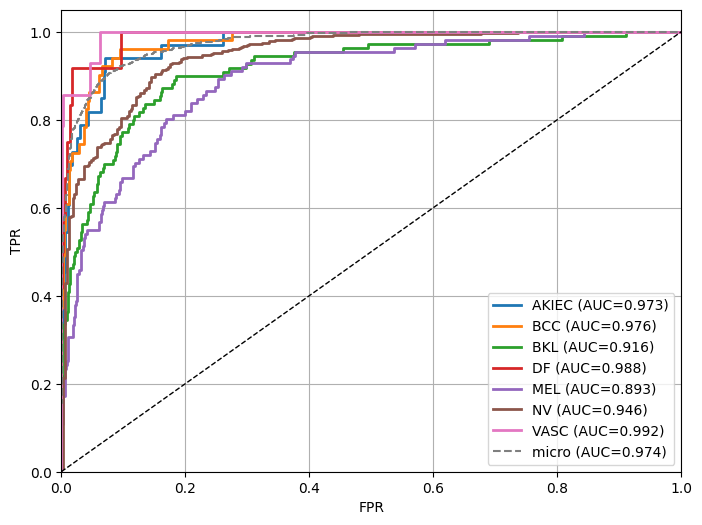

Found 8012 validated image filenames belonging to 7 classes.
Found 1001 validated image filenames belonging to 7 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.5570 - loss: 0.2595

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.71029, saving model to results_resnet/resnet_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 155s 570ms/step - accuracy: 0.5572 - loss: 0.2594 - val_accuracy: 0.7103 - val_loss: 0.1181 - learning_rate: 1.0000e-04
Epoch 2/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.6356 - loss: 0.1796
Epoch 2: val_accuracy improved from 0.71029 to 0.71928, saving model to results_resnet/resnet_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 129s 517ms/step - accuracy: 0.6356 - loss: 0.1796 - val_accuracy: 0.7193 - val_loss: 0.1088 - learning_rate: 1.0000e-04
Epoch 3/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.6625 - loss: 0.1582
Epoch 3: val_accuracy improved from 0.71928 to 0.73926, saving model to results_resnet/resnet_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 128s 513ms/step - accuracy: 0.6625 - loss: 0.1582 - val_accuracy: 0.7393 - val_loss: 0.0987 - learning_rate: 1.0000e-04
Epoch 4/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.6719 - loss: 0.1488
Epoch 4: val_accuracy improved from 0.73926 to 0.75524, saving model to results_resnet/resnet_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 126s 505ms/step - accuracy: 0.6720 - loss: 0.1487 - val_accuracy: 0.7552 - val_loss: 0.0952 - learning_rate: 1.0000e-04
Epoch 5/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.6867 - loss: 0.1427
Epoch 5: val_accuracy improved from 0.75524 to 0.75824, saving model to results_resnet/resnet_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 124s 495ms/step - accuracy: 0.6867 - loss: 0.1427 - val_accuracy: 0.7582 - val_loss: 0.0934 - learning_rate: 1.0000e-04
Epoch 6/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.6799 - loss: 0.1400
Epoch 6: val_accuracy improved from 0.75824 to 0.76923, saving model to results_resnet/resnet_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 125s 498ms/step - accuracy: 0.6800 - loss: 0.1400 - val_accuracy: 0.7692 - val_loss: 0.0940 - learning_rate: 1.0000e-04
Epoch 7/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.6951 - loss: 0.1353
Epoch 7: val_accuracy did not improve from 0.76923
251/251 ━━━━━━━━━━━━━━━━━━━━ 122s 488ms/step - accuracy: 0.6951 - loss: 0.1353 - val_accuracy: 0.7602 - val_loss: 0.0925 - learning_rate: 1.0000e-04
Epoch 8/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.7108 - loss: 0.1259
Epoch 8: val_accuracy did not improve from 0.76923
251/251 ━━━━━━━━━━━━━━━━━━━━ 123s 491ms/step - accuracy: 0.7107 - loss: 0.1259 - val_accuracy: 0.7632 - val_loss: 0.0913 - learning_rate: 1.0000e-04
Epoch 9/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.7060 - loss: 0.1302
Epoch 9: val_accuracy did not improve from 0.76923
251/251 ━━━━━━━━━━━━━━━━━━━━ 123s 493ms/step - accuracy: 0.7060 - loss: 0.1302 - val_accuracy: 0.7572 - val_loss: 0.0889 - learning_rate

251/251 ━━━━━━━━━━━━━━━━━━━━ 124s 496ms/step - accuracy: 0.7213 - loss: 0.1250 - val_accuracy: 0.7742 - val_loss: 0.0839 - learning_rate: 1.0000e-04
Epoch 13/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.7219 - loss: 0.1206
Epoch 13: val_accuracy improved from 0.77423 to 0.78122, saving model to results_resnet/resnet_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 124s 496ms/step - accuracy: 0.7219 - loss: 0.1206 - val_accuracy: 0.7812 - val_loss: 0.0822 - learning_rate: 1.0000e-04
Epoch 14/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.7303 - loss: 0.1181
Epoch 14: val_accuracy did not improve from 0.78122
251/251 ━━━━━━━━━━━━━━━━━━━━ 123s 491ms/step - accuracy: 0.7303 - loss: 0.1181 - val_accuracy: 0.7782 - val_loss: 0.0805 - learning_rate: 1.0000e-04
Epoch 15/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.7247 - loss: 0.1236
Epoch 15: val_accuracy did not improve from 0.78122
251/251 ━━━━━━━━━━━━━━━━━━━━ 123s 494ms/step - accuracy: 0.7246 - loss: 0.1236 - val_accuracy: 0.7742 - val_loss: 0.0788 - learning_rate: 1.0000e-04
Epoch 16/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.7334 - loss: 0.1189
Epoch 16: val_accuracy improved from 0.78122 to 0.78521, saving model to results_resnet/resnet_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 124s 496ms/step - accuracy: 0.7334 - loss: 0.1189 - val_accuracy: 0.7852 - val_loss: 0.0761 - learning_rate: 1.0000e-04
Epoch 17/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.7237 - loss: 0.1205
Epoch 17: val_accuracy improved from 0.78521 to 0.78821, saving model to results_resnet/resnet_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 124s 495ms/step - accuracy: 0.7238 - loss: 0.1204 - val_accuracy: 0.7882 - val_loss: 0.0753 - learning_rate: 1.0000e-04
Epoch 18/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.7355 - loss: 0.1134
Epoch 18: val_accuracy improved from 0.78821 to 0.78921, saving model to results_resnet/resnet_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 124s 494ms/step - accuracy: 0.7355 - loss: 0.1134 - val_accuracy: 0.7892 - val_loss: 0.0748 - learning_rate: 1.0000e-04
Epoch 19/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.7411 - loss: 0.1129
Epoch 19: val_accuracy did not improve from 0.78921
251/251 ━━━━━━━━━━━━━━━━━━━━ 123s 491ms/step - accuracy: 0.7410 - loss: 0.1129 - val_accuracy: 0.7842 - val_loss: 0.0757 - learning_rate: 1.0000e-04
Epoch 20/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.7149 - loss: 0.1232
Epoch 20: val_accuracy improved from 0.78921 to 0.79221, saving model to results_resnet/resnet_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 124s 495ms/step - accuracy: 0.7150 - loss: 0.1232 - val_accuracy: 0.7922 - val_loss: 0.0745 - learning_rate: 1.0000e-04
Epoch 21/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.7314 - loss: 0.1193
Epoch 21: val_accuracy improved from 0.79221 to 0.79421, saving model to results_resnet/resnet_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 123s 492ms/step - accuracy: 0.7314 - loss: 0.1192 - val_accuracy: 0.7942 - val_loss: 0.0740 - learning_rate: 1.0000e-04
Epoch 22/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.7342 - loss: 0.1133
Epoch 22: val_accuracy improved from 0.79421 to 0.79620, saving model to results_resnet/resnet_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 124s 494ms/step - accuracy: 0.7343 - loss: 0.1133 - val_accuracy: 0.7962 - val_loss: 0.0735 - learning_rate: 1.0000e-04
Epoch 23/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.7350 - loss: 0.1133
Epoch 23: val_accuracy improved from 0.79620 to 0.80020, saving model to results_resnet/resnet_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 123s 494ms/step - accuracy: 0.7350 - loss: 0.1133 - val_accuracy: 0.8002 - val_loss: 0.0721 - learning_rate: 1.0000e-04
Epoch 24/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.7225 - loss: 0.1211
Epoch 24: val_accuracy did not improve from 0.80020
251/251 ━━━━━━━━━━━━━━━━━━━━ 123s 492ms/step - accuracy: 0.7226 - loss: 0.1211 - val_accuracy: 0.7822 - val_loss: 0.0741 - learning_rate: 1.0000e-04
Epoch 25/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.7327 - loss: 0.1166
Epoch 25: val_accuracy did not improve from 0.80020
251/251 ━━━━━━━━━━━━━━━━━━━━ 123s 494ms/step - accuracy: 0.7327 - loss: 0.1166 - val_accuracy: 0.7852 - val_loss: 0.0727 - learning_rate: 1.0000e-04
Epoch 26/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.7423 - loss: 0.1123
Epoch 26: val_accuracy did not improve from 0.80020

Epoch 26: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
251/251 ━━━━━━━━━━━━━━━━━━━━ 123s 493ms/step - accur

251/251 ━━━━━━━━━━━━━━━━━━━━ 127s 510ms/step - accuracy: 0.7419 - loss: 0.1108 - val_accuracy: 0.8012 - val_loss: 0.0737 - learning_rate: 1.0000e-05
Epoch 4/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.7385 - loss: 0.1137
Epoch 4: val_accuracy improved from 0.80120 to 0.80220, saving model to results_resnet/resnet_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 124s 496ms/step - accuracy: 0.7385 - loss: 0.1137 - val_accuracy: 0.8022 - val_loss: 0.0724 - learning_rate: 1.0000e-05
Epoch 5/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.7570 - loss: 0.1038
Epoch 5: val_accuracy improved from 0.80220 to 0.80320, saving model to results_resnet/resnet_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 123s 494ms/step - accuracy: 0.7570 - loss: 0.1038 - val_accuracy: 0.8032 - val_loss: 0.0706 - learning_rate: 1.0000e-05
Epoch 6/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.7576 - loss: 0.1023
Epoch 6: val_accuracy improved from 0.80320 to 0.81518, saving model to results_resnet/resnet_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 124s 496ms/step - accuracy: 0.7576 - loss: 0.1024 - val_accuracy: 0.8152 - val_loss: 0.0679 - learning_rate: 1.0000e-05
Epoch 7/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.7531 - loss: 0.1048
Epoch 7: val_accuracy improved from 0.81518 to 0.81918, saving model to results_resnet/resnet_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 124s 495ms/step - accuracy: 0.7531 - loss: 0.1048 - val_accuracy: 0.8192 - val_loss: 0.0676 - learning_rate: 1.0000e-05
Epoch 8/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.7650 - loss: 0.0982
Epoch 8: val_accuracy improved from 0.81918 to 0.82218, saving model to results_resnet/resnet_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 124s 496ms/step - accuracy: 0.7650 - loss: 0.0982 - val_accuracy: 0.8222 - val_loss: 0.0657 - learning_rate: 1.0000e-05
Epoch 9/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.7678 - loss: 0.1003
Epoch 9: val_accuracy improved from 0.82218 to 0.83017, saving model to results_resnet/resnet_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 124s 495ms/step - accuracy: 0.7678 - loss: 0.1003 - val_accuracy: 0.8302 - val_loss: 0.0632 - learning_rate: 1.0000e-05
Epoch 10/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.7660 - loss: 0.1020
Epoch 10: val_accuracy improved from 0.83017 to 0.83317, saving model to results_resnet/resnet_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 125s 502ms/step - accuracy: 0.7660 - loss: 0.1020 - val_accuracy: 0.8332 - val_loss: 0.0616 - learning_rate: 1.0000e-05
Epoch 11/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.7708 - loss: 0.0948
Epoch 11: val_accuracy did not improve from 0.83317
251/251 ━━━━━━━━━━━━━━━━━━━━ 121s 485ms/step - accuracy: 0.7708 - loss: 0.0948 - val_accuracy: 0.8282 - val_loss: 0.0625 - learning_rate: 1.0000e-05
Epoch 12/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.7798 - loss: 0.0940
Epoch 12: val_accuracy did not improve from 0.83317
251/251 ━━━━━━━━━━━━━━━━━━━━ 122s 487ms/step - accuracy: 0.7797 - loss: 0.0940 - val_accuracy: 0.8302 - val_loss: 0.0610 - learning_rate: 1.0000e-05
Epoch 13/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.7809 - loss: 0.1003
Epoch 13: val_accuracy did not improve from 0.83317
251/251 ━━━━━━━━━━━━━━━━━━━━ 122s 487ms/step - accuracy: 0.7809 - loss: 0.1003 - val_accuracy: 0.8292 - val_loss: 0.0611 - learnin

251/251 ━━━━━━━━━━━━━━━━━━━━ 123s 491ms/step - accuracy: 0.7839 - loss: 0.0903 - val_accuracy: 0.8382 - val_loss: 0.0604 - learning_rate: 1.0000e-05
Epoch 15/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.7866 - loss: 0.0931
Epoch 15: val_accuracy did not improve from 0.83816
251/251 ━━━━━━━━━━━━━━━━━━━━ 121s 486ms/step - accuracy: 0.7866 - loss: 0.0931 - val_accuracy: 0.8342 - val_loss: 0.0611 - learning_rate: 1.0000e-05
Epoch 16/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.7703 - loss: 0.0960
Epoch 16: val_accuracy did not improve from 0.83816
251/251 ━━━━━━━━━━━━━━━━━━━━ 122s 490ms/step - accuracy: 0.7703 - loss: 0.0960 - val_accuracy: 0.8372 - val_loss: 0.0598 - learning_rate: 1.0000e-05
Epoch 17/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.7819 - loss: 0.0910
Epoch 17: val_accuracy improved from 0.83816 to 0.84615, saving model to results_resnet/resnet_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 123s 494ms/step - accuracy: 0.7819 - loss: 0.0910 - val_accuracy: 0.8462 - val_loss: 0.0596 - learning_rate: 1.0000e-05
Epoch 18/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.8075 - loss: 0.0851
Epoch 18: val_accuracy did not improve from 0.84615
251/251 ━━━━━━━━━━━━━━━━━━━━ 121s 485ms/step - accuracy: 0.8074 - loss: 0.0851 - val_accuracy: 0.8332 - val_loss: 0.0617 - learning_rate: 1.0000e-05
Epoch 19/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.7977 - loss: 0.0895
Epoch 19: val_accuracy improved from 0.84615 to 0.84815, saving model to results_resnet/resnet_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 124s 495ms/step - accuracy: 0.7977 - loss: 0.0894 - val_accuracy: 0.8482 - val_loss: 0.0570 - learning_rate: 1.0000e-05
Epoch 20/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.8093 - loss: 0.0807
Epoch 20: val_accuracy did not improve from 0.84815
251/251 ━━━━━━━━━━━━━━━━━━━━ 123s 490ms/step - accuracy: 0.8092 - loss: 0.0807 - val_accuracy: 0.8472 - val_loss: 0.0600 - learning_rate: 1.0000e-05
Epoch 21/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.8004 - loss: 0.0846
Epoch 21: val_accuracy did not improve from 0.84815
251/251 ━━━━━━━━━━━━━━━━━━━━ 124s 494ms/step - accuracy: 0.8004 - loss: 0.0846 - val_accuracy: 0.8472 - val_loss: 0.0570 - learning_rate: 1.0000e-05
Epoch 22/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.7881 - loss: 0.0860
Epoch 22: val_accuracy improved from 0.84815 to 0.85015, saving model to results_resnet/resnet_best.h5



Epoch 22: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
251/251 ━━━━━━━━━━━━━━━━━━━━ 124s 497ms/step - accuracy: 0.7881 - loss: 0.0860 - val_accuracy: 0.8501 - val_loss: 0.0581 - learning_rate: 1.0000e-05
Epoch 23/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.8004 - loss: 0.0851
Epoch 23: val_accuracy improved from 0.85015 to 0.85115, saving model to results_resnet/resnet_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 124s 497ms/step - accuracy: 0.8004 - loss: 0.0851 - val_accuracy: 0.8511 - val_loss: 0.0571 - learning_rate: 5.0000e-06
Epoch 24/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.7883 - loss: 0.0857
Epoch 24: val_accuracy improved from 0.85115 to 0.85315, saving model to results_resnet/resnet_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 123s 494ms/step - accuracy: 0.7884 - loss: 0.0857 - val_accuracy: 0.8531 - val_loss: 0.0568 - learning_rate: 5.0000e-06
Epoch 25/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.8013 - loss: 0.0832
Epoch 25: val_accuracy improved from 0.85315 to 0.85714, saving model to results_resnet/resnet_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 122s 489ms/step - accuracy: 0.8013 - loss: 0.0832 - val_accuracy: 0.8571 - val_loss: 0.0557 - learning_rate: 5.0000e-06
Epoch 26/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.8017 - loss: 0.0847
Epoch 26: val_accuracy did not improve from 0.85714
251/251 ━━━━━━━━━━━━━━━━━━━━ 121s 485ms/step - accuracy: 0.8017 - loss: 0.0847 - val_accuracy: 0.8531 - val_loss: 0.0552 - learning_rate: 5.0000e-06
Epoch 27/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.7907 - loss: 0.0840
Epoch 27: val_accuracy did not improve from 0.85714
251/251 ━━━━━━━━━━━━━━━━━━━━ 122s 488ms/step - accuracy: 0.7908 - loss: 0.0840 - val_accuracy: 0.8521 - val_loss: 0.0549 - learning_rate: 5.0000e-06
Epoch 28/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.8212 - loss: 0.0760
Epoch 28: val_accuracy did not improve from 0.85714
251/251 ━━━━━━━━━━━━━━━━━━━━ 122s 489ms/step - accuracy: 0.8212 - loss: 0.0760 - val_accuracy: 0.8571 - val_loss: 0.0558 - learnin

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 328ms/step
              precision    recall  f1-score   support

       AKIEC     0.8000    0.4848    0.6038        33
         BCC     0.8049    0.6471    0.7174        51
         BKL     0.7217    0.7545    0.7378       110
          DF     0.8750    0.5833    0.7000        12
         MEL     0.7500    0.5676    0.6462       111
          NV     0.8944    0.9612    0.9266       670
        VASC     0.9231    0.8571    0.8889        14

    accuracy                         0.8571      1001
   macro avg     0.8242    0.6937    0.7458      1001
weighted avg     0.8519    0.8571    0.8502      1001



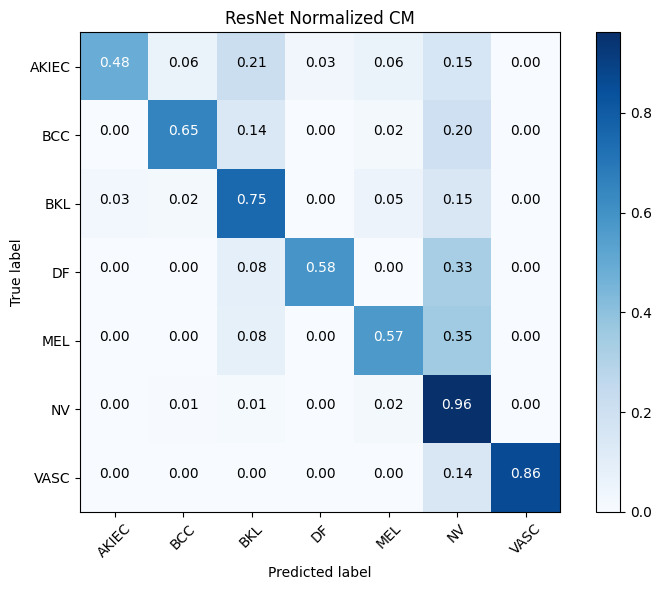

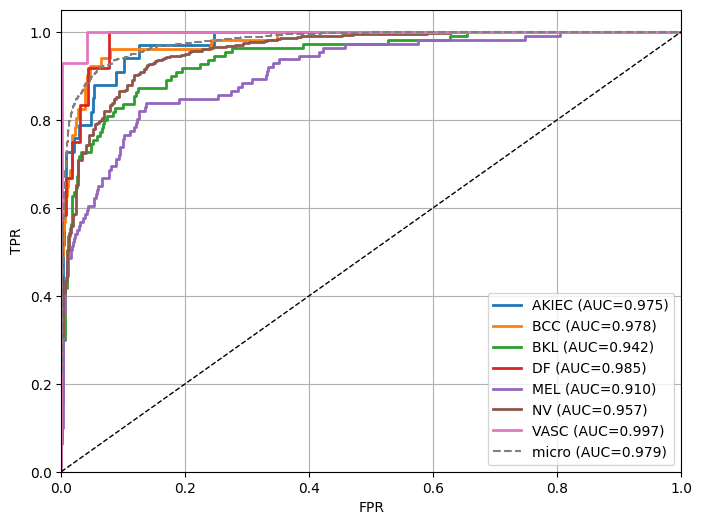

Found 8012 validated image filenames belonging to 7 classes.
Found 1001 validated image filenames belonging to 7 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.5556 - loss: 1.5139
Epoch 1: val_accuracy improved from -inf to 0.70529, saving model to results_mobilenet/mobilenet_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 190s 660ms/step - accuracy: 0.5559 - loss: 1.5131 - val_accuracy: 0.7053 - val_loss: 1.0929 - learning_rate: 1.0000e-04
Epoch 2/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.6922 - loss: 1.1645
Epoch 2: val_accuracy improved from 0.70529 to 0.71828, saving model to results_mobilenet/mobilenet_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 128s 511ms/step - accuracy: 0.6922 - loss: 1.1645 - val_accuracy: 0.7183 - val_loss: 1.0500 - learning_rate: 1.0000e-04
Epoch 3/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.7134 - loss: 1.0964
Epoch 3: val_accuracy improved from 0.71828 to 0.73427, saving model to results_mobilenet/mobilenet_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 128s 510ms/step - accuracy: 0.7134 - loss: 1.0964 - val_accuracy: 0.7343 - val_loss: 1.0321 - learning_rate: 1.0000e-04
Epoch 4/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.7299 - loss: 1.0597
Epoch 4: val_accuracy improved from 0.73427 to 0.73526, saving model to results_mobilenet/mobilenet_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 128s 511ms/step - accuracy: 0.7299 - loss: 1.0597 - val_accuracy: 0.7353 - val_loss: 1.0127 - learning_rate: 1.0000e-04
Epoch 5/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.7415 - loss: 1.0301
Epoch 5: val_accuracy improved from 0.73526 to 0.73926, saving model to results_mobilenet/mobilenet_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 128s 508ms/step - accuracy: 0.7415 - loss: 1.0301 - val_accuracy: 0.7393 - val_loss: 1.0146 - learning_rate: 1.0000e-04
Epoch 6/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.7308 - loss: 1.0376
Epoch 6: val_accuracy improved from 0.73926 to 0.75425, saving model to results_mobilenet/mobilenet_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 128s 511ms/step - accuracy: 0.7308 - loss: 1.0375 - val_accuracy: 0.7542 - val_loss: 0.9959 - learning_rate: 1.0000e-04
Epoch 7/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.7474 - loss: 1.0116
Epoch 7: val_accuracy improved from 0.75425 to 0.76124, saving model to results_mobilenet/mobilenet_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 127s 506ms/step - accuracy: 0.7474 - loss: 1.0116 - val_accuracy: 0.7612 - val_loss: 0.9890 - learning_rate: 1.0000e-04
Epoch 8/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.7535 - loss: 0.9819
Epoch 8: val_accuracy did not improve from 0.76124
251/251 ━━━━━━━━━━━━━━━━━━━━ 127s 504ms/step - accuracy: 0.7535 - loss: 0.9819 - val_accuracy: 0.7493 - val_loss: 0.9948 - learning_rate: 1.0000e-04
Epoch 9/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.7561 - loss: 0.9827
Epoch 9: val_accuracy did not improve from 0.76124
251/251 ━━━━━━━━━━━━━━━━━━━━ 126s 503ms/step - accuracy: 0.7561 - loss: 0.9827 - val_accuracy: 0.7592 - val_loss: 0.9879 - learning_rate: 1.0000e-04
Epoch 10/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.7603 - loss: 0.9733
Epoch 10: val_accuracy did not improve from 0.76124
251/251 ━━━━━━━━━━━━━━━━━━━━ 127s 505ms/step - accuracy: 0.7603 - loss: 0.9733 - val_accuracy: 0.7612 - val_loss: 0.9938 - learning_ra

251/251 ━━━━━━━━━━━━━━━━━━━━ 127s 507ms/step - accuracy: 0.7641 - loss: 0.9517 - val_accuracy: 0.7672 - val_loss: 0.9661 - learning_rate: 1.0000e-04
Epoch 15/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.7756 - loss: 0.9322
Epoch 15: val_accuracy did not improve from 0.76723
251/251 ━━━━━━━━━━━━━━━━━━━━ 127s 508ms/step - accuracy: 0.7755 - loss: 0.9322 - val_accuracy: 0.7662 - val_loss: 0.9722 - learning_rate: 1.0000e-04
Epoch 16/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.7750 - loss: 0.9292
Epoch 16: val_accuracy did not improve from 0.76723
251/251 ━━━━━━━━━━━━━━━━━━━━ 128s 509ms/step - accuracy: 0.7750 - loss: 0.9292 - val_accuracy: 0.7572 - val_loss: 0.9822 - learning_rate: 1.0000e-04
Epoch 17/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.7794 - loss: 0.9201
Epoch 17: val_accuracy did not improve from 0.76723
251/251 ━━━━━━━━━━━━━━━━━━━━ 127s 507ms/step - accuracy: 0.7794 - loss: 0.9201 - val_accuracy: 0.7662 - val_loss: 0.9635 - learnin

251/251 ━━━━━━━━━━━━━━━━━━━━ 127s 507ms/step - accuracy: 0.7925 - loss: 0.9004 - val_accuracy: 0.7732 - val_loss: 0.9590 - learning_rate: 1.0000e-04
Epoch 21/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.7819 - loss: 0.9059
Epoch 21: val_accuracy improved from 0.77323 to 0.77922, saving model to results_mobilenet/mobilenet_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 128s 512ms/step - accuracy: 0.7819 - loss: 0.9059 - val_accuracy: 0.7792 - val_loss: 0.9556 - learning_rate: 1.0000e-04
Epoch 22/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.7944 - loss: 0.8970
Epoch 22: val_accuracy did not improve from 0.77922
251/251 ━━━━━━━━━━━━━━━━━━━━ 127s 506ms/step - accuracy: 0.7944 - loss: 0.8970 - val_accuracy: 0.7692 - val_loss: 0.9692 - learning_rate: 1.0000e-04
Epoch 23/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.8009 - loss: 0.8970
Epoch 23: val_accuracy did not improve from 0.77922
251/251 ━━━━━━━━━━━━━━━━━━━━ 127s 506ms/step - accuracy: 0.8008 - loss: 0.8970 - val_accuracy: 0.7612 - val_loss: 0.9807 - learning_rate: 1.0000e-04
Epoch 24/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.7898 - loss: 0.8998
Epoch 24: val_accuracy did not improve from 0.77922

Epoch 24: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
251/251 ━━━━━━━━━━━━━━━━━━━━ 127s 507ms/step - accur

251/251 ━━━━━━━━━━━━━━━━━━━━ 129s 512ms/step - accuracy: 0.7960 - loss: 0.9122 - val_accuracy: 0.7862 - val_loss: 0.9376 - learning_rate: 1.0000e-05
Epoch 10/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.8002 - loss: 0.8938
Epoch 10: val_accuracy improved from 0.78621 to 0.79321, saving model to results_mobilenet/mobilenet_best.h5


251/251 ━━━━━━━━━━━━━━━━━━━━ 128s 509ms/step - accuracy: 0.8002 - loss: 0.8938 - val_accuracy: 0.7932 - val_loss: 0.9320 - learning_rate: 1.0000e-05
Epoch 11/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.8082 - loss: 0.8833
Epoch 11: val_accuracy did not improve from 0.79321
251/251 ━━━━━━━━━━━━━━━━━━━━ 127s 506ms/step - accuracy: 0.8081 - loss: 0.8834 - val_accuracy: 0.7832 - val_loss: 0.9385 - learning_rate: 1.0000e-05
Epoch 12/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.8059 - loss: 0.8815
Epoch 12: val_accuracy did not improve from 0.79321
251/251 ━━━━━━━━━━━━━━━━━━━━ 128s 509ms/step - accuracy: 0.8059 - loss: 0.8815 - val_accuracy: 0.7802 - val_loss: 0.9525 - learning_rate: 1.0000e-05
Epoch 13/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.8110 - loss: 0.8728
Epoch 13: val_accuracy did not improve from 0.79321

Epoch 13: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
251/251 ━━━━━━━━━━━━━━━━━━━━ 127s 505ms/step - accur

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 332ms/step
              precision    recall  f1-score   support

       AKIEC     0.7000    0.2121    0.3256        33
         BCC     0.7143    0.3922    0.5063        51
         BKL     0.6344    0.5364    0.5813       110
          DF     0.0000    0.0000    0.0000        12
         MEL     0.5268    0.5315    0.5291       111
          NV     0.8591    0.9552    0.9046       670
        VASC     0.6923    0.6429    0.6667        14

    accuracy                         0.7932      1001
   macro avg     0.5895    0.4672    0.5019      1001
weighted avg     0.7723    0.7932    0.7739      1001



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


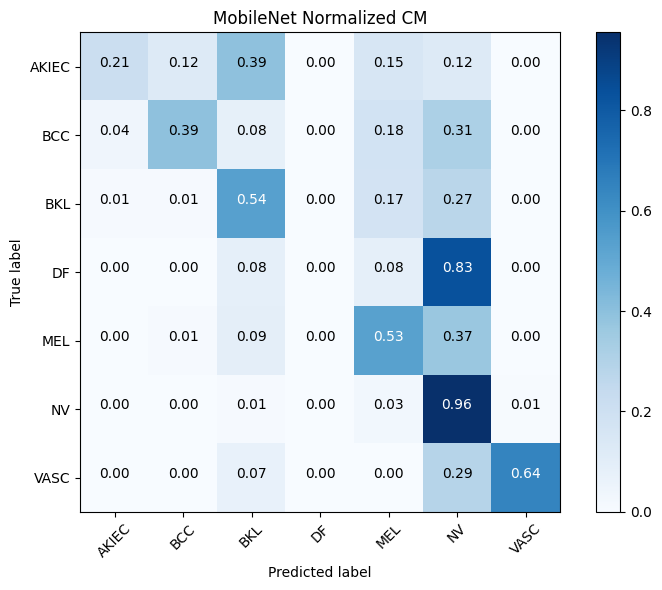

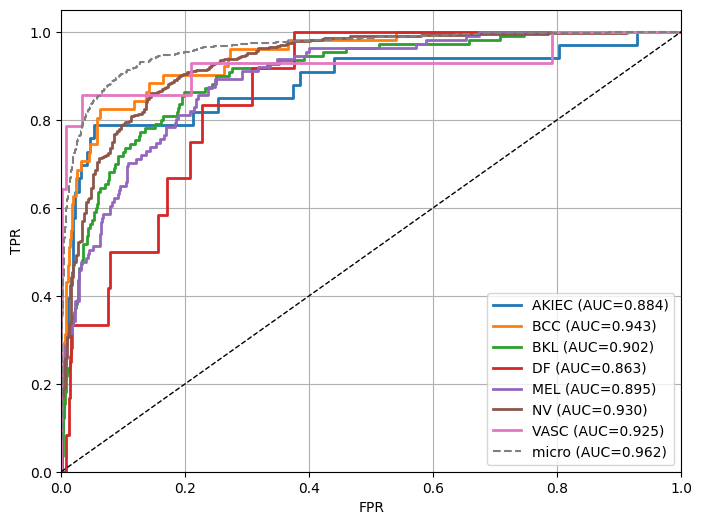

In [10]:
# Split data (train/val/test)
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['dx'], random_state=SEED)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['dx'], random_state=SEED)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))

# VGG with MixUp + focal + fine-tune deep
res_vgg = train_model_pipeline('vgg', preprocess_vgg, train_df, val_df,
                              mix_strategy='mixup', focal=True, label_smooth=0.0,
                              fine_tune_at=15, epochs=30, outdir="results_vgg")

print(res_vgg['classification_report_text'])
plot_confusion_matrix(res_vgg['confusion_matrix'], res_vgg['labels_order'], normalize=True, title='VGG Normalized CM')
plot_roc_multiclass(res_vgg['roc'], res_vgg['labels_order']); plt.show()

# ResNet (CutMix, focal)
res_resnet = train_model_pipeline('resnet', preprocess_resnet, train_df, val_df,
                                 mix_strategy='cutmix', focal=True, label_smooth=0.0,
                                 fine_tune_at=80, epochs=30, outdir="results_resnet")
print(res_resnet['classification_report_text'])
plot_confusion_matrix(res_resnet['confusion_matrix'], res_resnet['labels_order'], normalize=True, title='ResNet Normalized CM')
plot_roc_multiclass(res_resnet['roc'], res_resnet['labels_order']); plt.show()

# MobileNetV2 (no mix, label smoothing)
res_mobilenet = train_model_pipeline('mobilenet', preprocess_mobilenet, train_df, val_df,
                                    mix_strategy=None, focal=False, label_smooth=0.1,
                                    fine_tune_at=50, epochs=30, outdir="results_mobilenet")
print(res_mobilenet['classification_report_text'])
plot_confusion_matrix(res_mobilenet['confusion_matrix'], res_mobilenet['labels_order'], normalize=True, title='MobileNet Normalized CM')
plot_roc_multiclass(res_mobilenet['roc'], res_mobilenet['labels_order']); plt.show()


=== VGG16 Curves ===


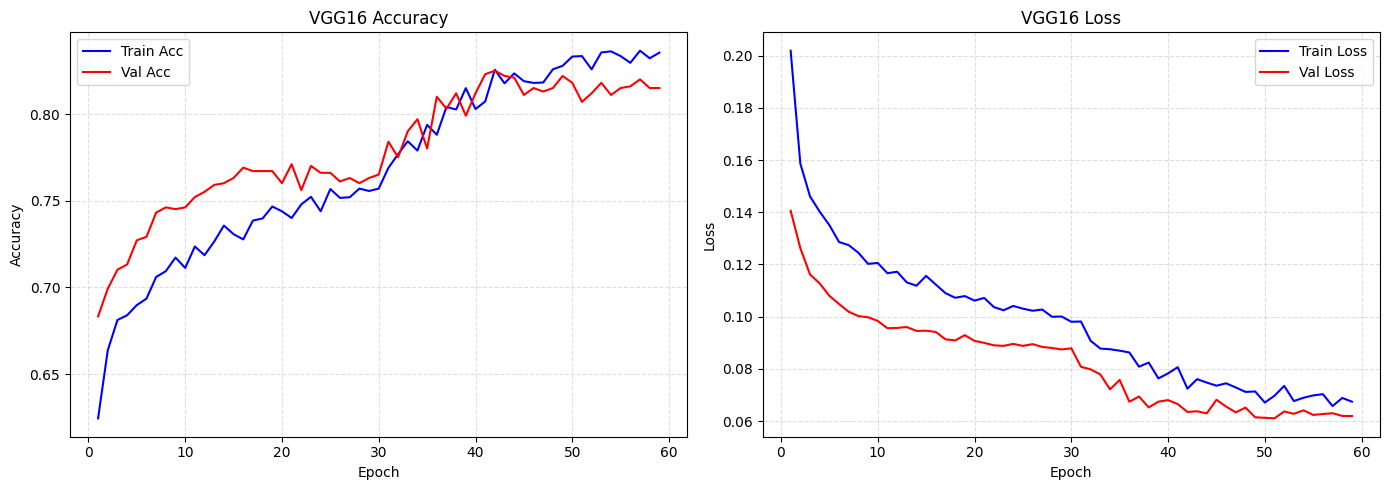

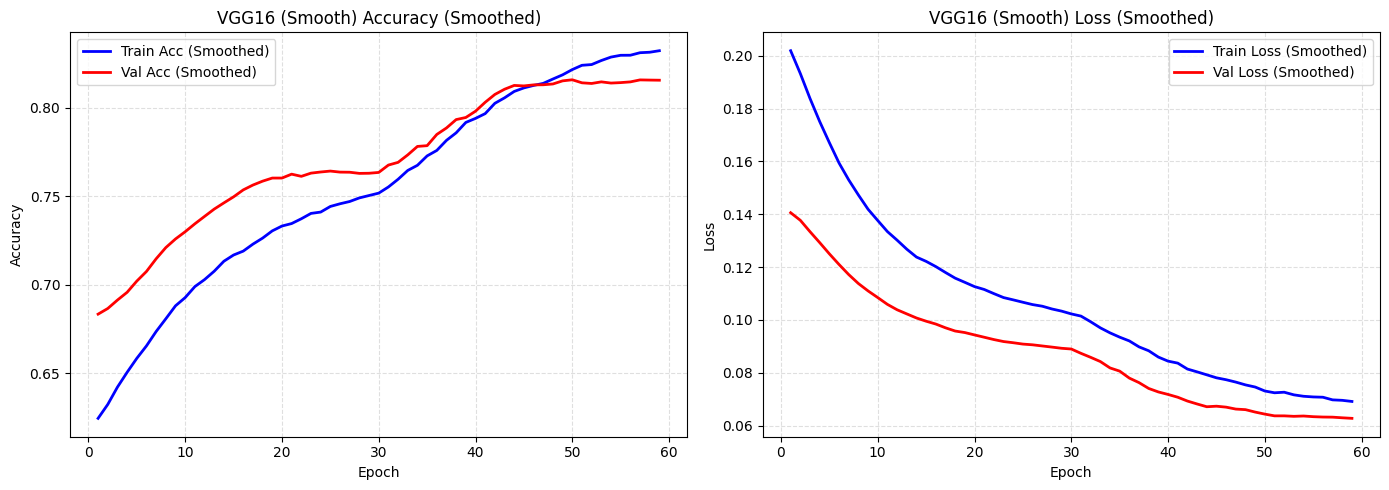

=== ResNet50 Curves ===


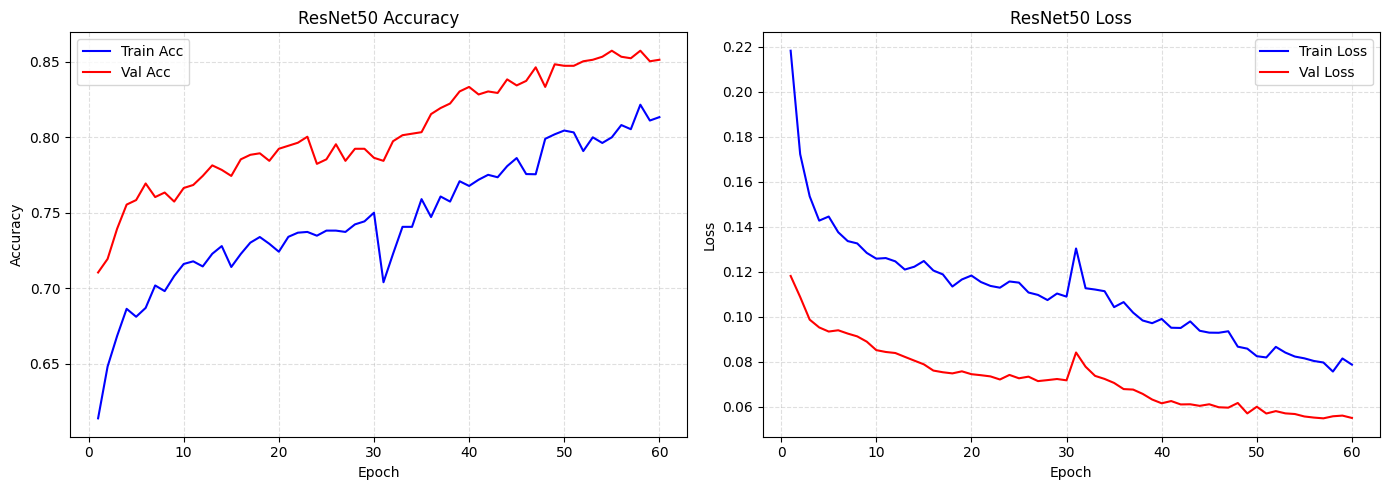

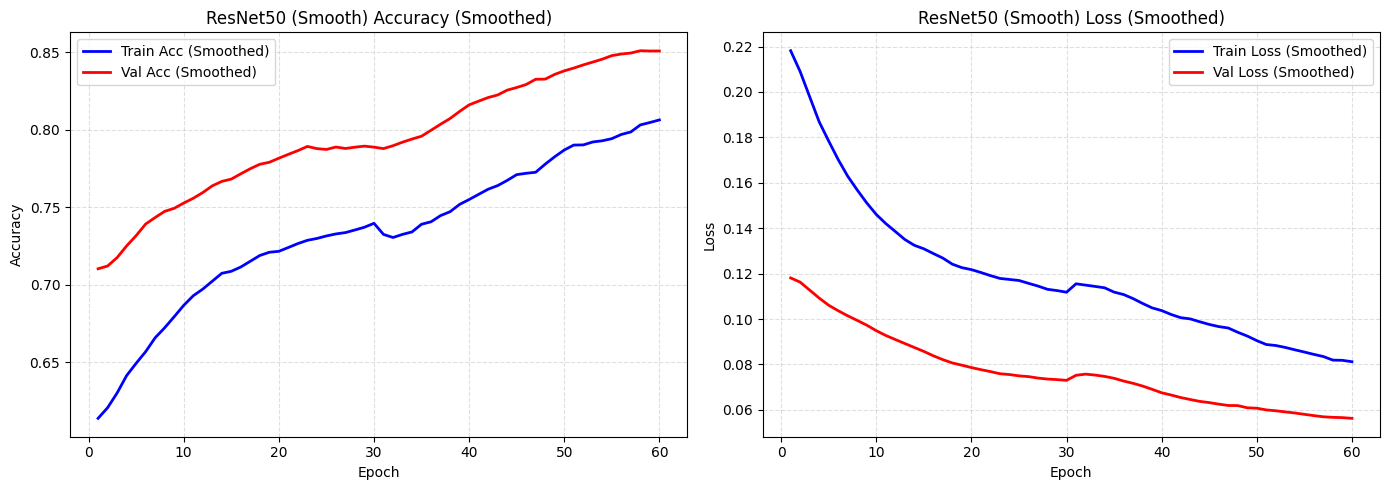

=== MobileNetV2 Curves ===


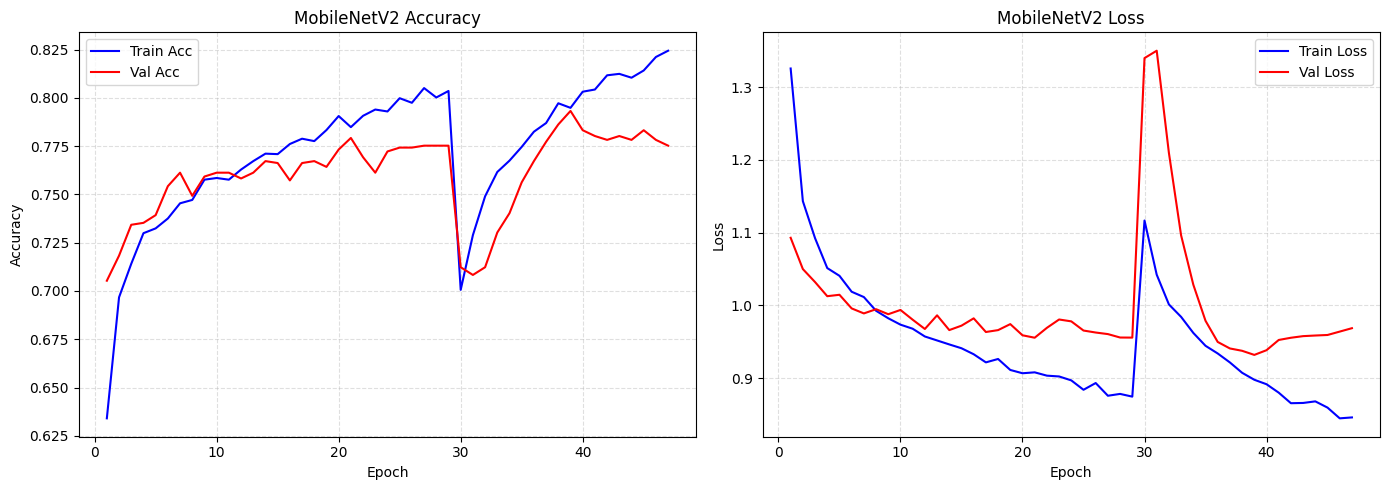

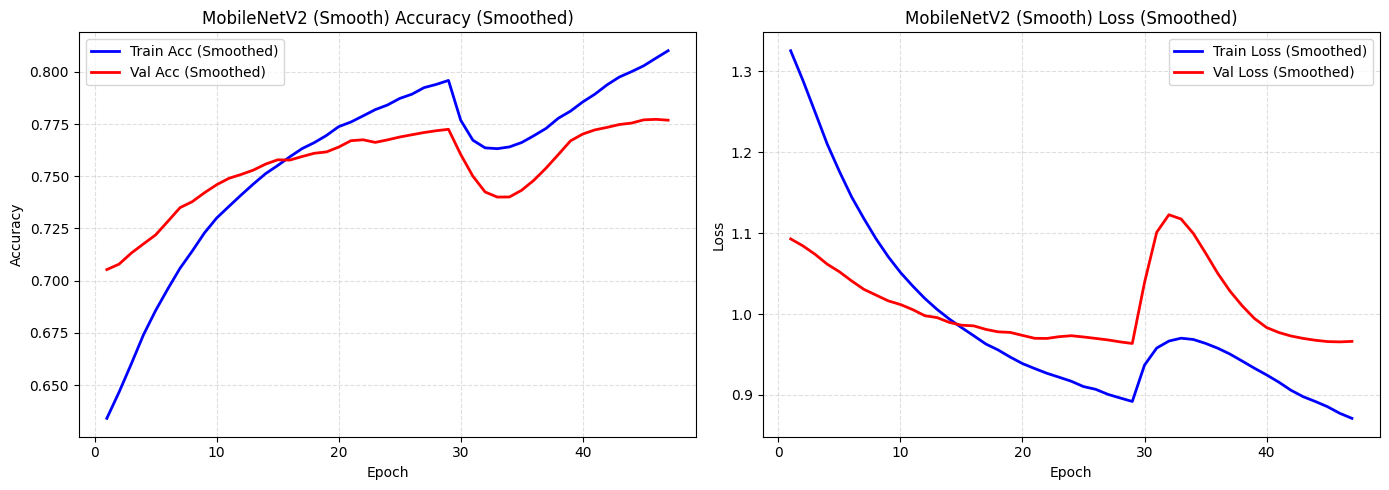

In [11]:
# ============================================================
# === TRAINING CURVE PLOTS (NORMAL + SMOOTH VERSION) =========
# ============================================================

def smooth_curve(points, factor=0.8):
    """Exponential moving average smoothing."""
    smoothed = []
    for p in points:
        if smoothed:
            smoothed.append(smoothed[-1] * factor + p * (1 - factor))
        else:
            smoothed.append(p)
    return smoothed


def plot_training_curves(history, title_prefix="Model"):
    """Plot original accuracy & loss curves."""
    acc = history.get('accuracy', [])
    val_acc = history.get('val_accuracy', [])
    loss = history.get('loss', [])
    val_loss = history.get('val_loss', [])

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b-', label='Train Acc')
    plt.plot(epochs, val_acc, 'r-', label='Val Acc')
    plt.title(f"{title_prefix} Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.grid(True, linestyle='--', alpha=0.4); plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b-', label='Train Loss')
    plt.plot(epochs, val_loss, 'r-', label='Val Loss')
    plt.title(f"{title_prefix} Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.grid(True, linestyle='--', alpha=0.4); plt.legend()

    plt.tight_layout()
    plt.show()


def plot_training_curves_smooth(history, title_prefix="Model", smooth_factor=0.8):
    """Plot smoothed accuracy & loss curves."""
    acc = history.get('accuracy', [])
    val_acc = history.get('val_accuracy', [])
    loss = history.get('loss', [])
    val_loss = history.get('val_loss', [])

    acc_s = smooth_curve(acc, smooth_factor)
    val_acc_s = smooth_curve(val_acc, smooth_factor)
    loss_s = smooth_curve(loss, smooth_factor)
    val_loss_s = smooth_curve(val_loss, smooth_factor)

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14,5))

    # Smoothed Accuracy
    plt.subplot(1,2,1)
    plt.plot(epochs, acc_s, 'b-', linewidth=2, label='Train Acc (Smoothed)')
    plt.plot(epochs, val_acc_s, 'r-', linewidth=2, label='Val Acc (Smoothed)')
    plt.title(f"{title_prefix} Accuracy (Smoothed)")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.grid(True, linestyle='--', alpha=0.4); plt.legend()

    # Smoothed Loss
    plt.subplot(1,2,2)
    plt.plot(epochs, loss_s, 'b-', linewidth=2, label='Train Loss (Smoothed)')
    plt.plot(epochs, val_loss_s, 'r-', linewidth=2, label='Val Loss (Smoothed)')
    plt.title(f"{title_prefix} Loss (Smoothed)")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.grid(True, linestyle='--', alpha=0.4); plt.legend()

    plt.tight_layout()
    plt.show()


# ============================================================
# === TAMPILKAN CURVES UNTUK SEMUA MODEL =====================
# ============================================================

print("=== VGG16 Curves ===")
plot_training_curves(res_vgg['history'], "VGG16")
plot_training_curves_smooth(res_vgg['history'], "VGG16 (Smooth)")

print("=== ResNet50 Curves ===")
plot_training_curves(res_resnet['history'], "ResNet50")
plot_training_curves_smooth(res_resnet['history'], "ResNet50 (Smooth)")

print("=== MobileNetV2 Curves ===")
plot_training_curves(res_mobilenet['history'], "MobileNetV2")
plot_training_curves_smooth(res_mobilenet['history'], "MobileNetV2 (Smooth)")
